# 朴素贝叶斯

1．朴素贝叶斯法是典型的生成学习方法。生成方法由训练数据学习联合概率分布 $P(X,Y)$，然后求得后验概率分布$P(Y|X)$。具体来说，利用训练数据学习$P(X|Y)$和$P(Y)$的估计，得到联合概率分布：

$$P(X,Y)＝P(Y)P(X|Y)$$
概率估计方法可以是极大似然估计或贝叶斯估计。

2．朴素贝叶斯法的基本假设是条件独立性，

$$\begin{aligned} P(X=x | Y=c_{k} )=P\left(X^{(1)}=x^{(1)}, \cdots, X^{(n)}=x^{(n)} | Y=c_{k}\right) \\ =\prod_{j=1}^{n} P\left(X^{(j)}=x^{(j)} | Y=c_{k}\right) \end{aligned}$$
这是一个较强的假设。由于这一假设，模型包含的条件概率的数量大为减少，朴素贝叶斯法的学习与预测大为简化。因而朴素贝叶斯法高效，且易于实现。其缺点是分类的性能不一定很高。

3．朴素贝叶斯法利用贝叶斯定理与学到的联合概率模型进行分类预测。

$$P(Y | X)=\frac{P(X, Y)}{P(X)}=\frac{P(Y) P(X | Y)}{\sum_{Y} P(Y) P(X | Y)}$$
将输入$x$分到后验概率最大的类$y$。

$$y=\arg \max _{c_{k}} P\left(Y=c_{k}\right) \prod_{j=1}^{n} P\left(X_{j}=x^{(j)} | Y=c_{k}\right)$$
后验概率最大等价于0-1损失函数时的期望风险最小化。

模型：

高斯模型
多项式模型
伯努利模型

以上部分来自[github lihang-code](https://github.com/fengdu78/lihang-code/blob/master/%E7%AC%AC04%E7%AB%A0%20%E6%9C%B4%E7%B4%A0%E8%B4%9D%E5%8F%B6%E6%96%AF/4.NaiveBayes.ipynb)

In [125]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
import math
from sklearn.model_selection import train_test_split

%matplotlib inline

M = 2
X, y = make_classification(n_samples=100, n_features=M, n_classes=3, n_clusters_per_class=1, n_informative=M, n_redundant=0, n_repeated=0)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)
labels = np.unique(y)

In [126]:
df = pd.DataFrame(np.c_[X, y], columns=['feature_{}'.format(i+1) for i in range(M)]+['label'])
df.head()

,feature_1,feature_2,label
0,-1.592614,-1.292169,0.0
1,0.676972,0.935414,2.0
2,-2.004239,-1.549395,0.0
3,1.216495,0.732870,2.0
4,0.115092,0.511923,2.0


高斯密度函数

$$
f(x; \mu, \sigma) = \frac{1}{\sqrt {2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

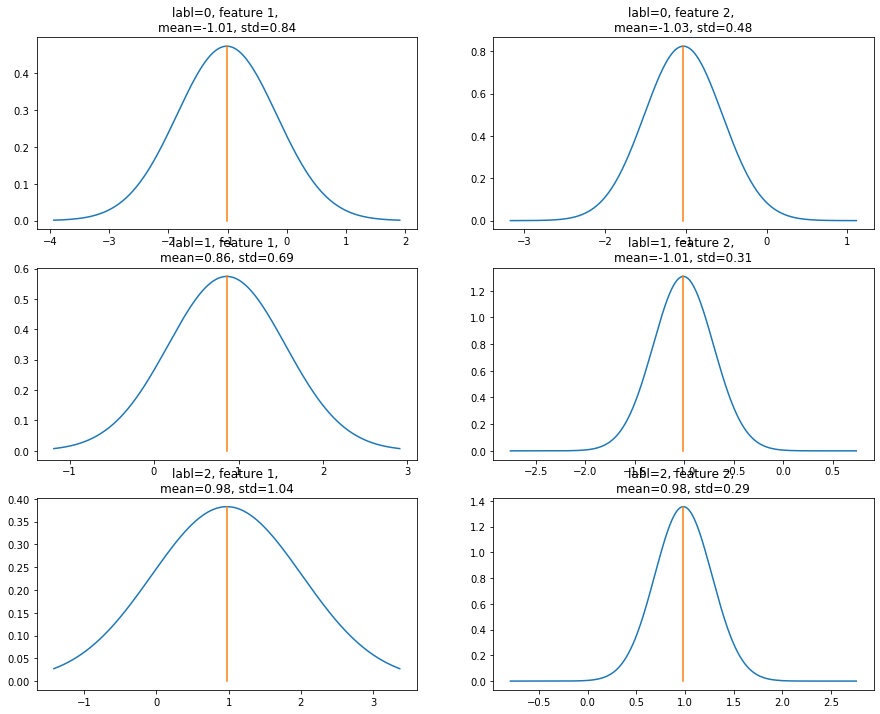

In [138]:
def gaussian(x, mean, std):
    var = std**2
    return 1.0 / math.sqrt(2*math.pi*var) * math.exp(-math.pow(x-mean, 2)/(2*var))
        

plt.figure(figsize=(15, 12))
plot_index = 0
for label in labels:
    for i in range(M):
        plot_index += 1
        ax = plt.subplot(labels.size*100+M*10+plot_index)
        x = X[y==label][:, i]
        m, s = np.mean(x), np.std(x)
        xa = max(abs(min(x)), abs(max(x)))
        x = np.linspace(m-xa, m+xa, 1000)
        p = [gaussian(v, m, s) for v in x]

        ax.plot(x, p)
        ax.set_title('labl={:.0f}, feature {:.0f}, \nmean={:.2f}, std={:.2f}'.format(label, i+1, m, s))
        ax.plot([m, m], [0, max(p)])

先验概率

$$
P(Y=c_k) = \frac{\sum_{i=1}^NI(y_i=c_k)}{N}, k=1,2,\ldots,K
$$

In [139]:
N = X.shape[0]
yprior = {c: (y==c).sum()/N for c in C}
yprior

{0: 0.3333333333333333, 1: 0.3111111111111111, 2: 0.35555555555555557}

对于给的的实例$x=(x_1, x_2, \ldots, x_n)^T$,计算

$$
P(Y=c_k)\prod_{j=1}^NP(X^{(j)}=x^{(j)}|Y=c_k), k=1,2,\ldots,K
$$

其中$P(X^{(j)}=x^{(j)}|Y=c_k)$是第$j$个特征的值等于$x^{(j)}$的概率.

In [144]:
feature_mean = {label:[0]*X.shape[1] for label in labels}
feature_std = {label:[0]*X.shape[1] for label in labels}

for l in labels:
    x = X[y==l]
    for i in range(x.shape[1]):
        vals = x[:, i]
        feature_mean[l][i], feature_std[l][i] = np.mean(vals), np.std(vals)
    
print(feature_mean, feature_std)
    
def prob(label, x):
    p = 1
    for i in range(x.shape[0]):
        p *= gaussian(x[i], feature_mean[label][i], feature_std[label][i])
    p *= yprior[label]
    return p



{0: [-1.0124046803895221, -1.0314614443161305], 1: [0.8614392595080477, -1.0101324557292912], 2: [0.9751114066077802, 0.9830249635521614]} {0: [0.8421465722235351, 0.48394156001243027], 1: [0.6944559369446375, 0.305054590341305], 2: [1.0413421712103783, 0.29427949247910445]}


确定实例$x$的分类:

$$
y = arg\ \underset{c_k}{\max}P(Y=c_k)\prod_{j=1}^NP(X^{(j)}=x^{(j)}|Y=c_k)
$$

In [180]:
def predict(x):
    ypred = C[np.argmax([prob(c, x) for c in labels])]
    return ypred

x = np.random.rand(M)
print({c: prob(c, x) for c in labels})
predict(x)

{0: 0.0009315362939052584, 1: 0.00016860933440759565, 2: 0.003116606573338837}


2

In [181]:
print(X_test)

[[-1.56373039 -1.37674811]
 [ 0.66989781 -0.79397757]
 [-1.9882549  -2.25246944]
 [ 0.84939777 -1.4489211 ]
 [ 0.17260721 -1.60919065]
 [-0.01431976  1.03648187]
 [ 0.20891279 -0.86218958]
 [-1.59893561 -1.21368655]
 [ 1.26804983 -0.84793184]
 [ 0.68938482 -0.84003743]]


Text(0.5, 1.0, 'acc=0.90')

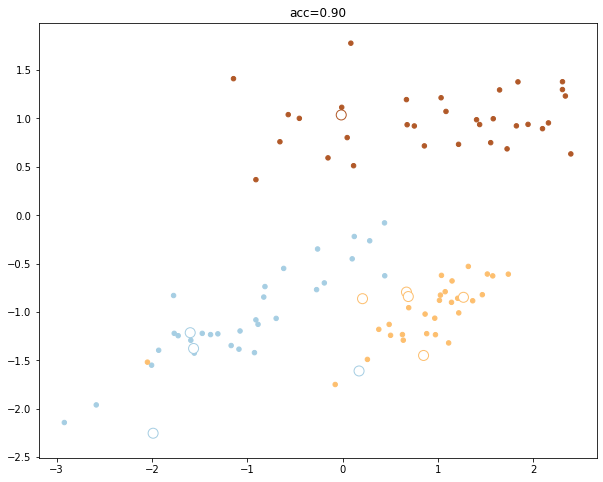

In [184]:
from sklearn.metrics import accuracy_score
import matplotlib
from matplotlib.colors import Normalize

cmap = matplotlib.cm.Paired
norm = Normalize(vmin=min(labels), vmax=max(labels))
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], cmap=cmap, c=y, s=20)
ypred = [predict(x) for x in X_test]
plt.scatter(X_test[:, 0], X_test[:, 1], fc='w', marker='o',  ec=[cmap(v) for v in norm(ypred)], s=100)
plt.title('acc={:.2f}'.format(accuracy_score(y_test, ypred)))